In [21]:
import pandas as pd
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [22]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
val_df = pd.read_csv('data/validate.csv')

In [23]:
X_train = [re.sub(r'[^\w\s]', '', text) for text in train_df['text']]
y_train = train_df['label']

X_test = [re.sub(r'[^\w\s]', '', text) for text in test_df['text']]
y_test = test_df['label']

X_val = [re.sub(r'[^\w\s]', '', text) for text in val_df['text']]
y_val = val_df['label']

y_val.unique()

array(['Personal', 'Geopolitical', 'Neutral', 'Religious', 'Political'],
      dtype=object)

In [24]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_val = count_vectorizer.transform(X_val)
count_test = count_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_val = tfidf_vectorizer.transform(X_val)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [25]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)

valid_score = nb_classifier.score(count_val, y_val)

predictions = nb_classifier.predict(count_test)
accuracy = metrics.accuracy_score(y_test, predictions)
cf_matrix = metrics.confusion_matrix(y_test, predictions, labels=y_test.unique())

print(valid_score)
print(accuracy)

0.7077777777777777
0.6622222222222223


<Axes: >

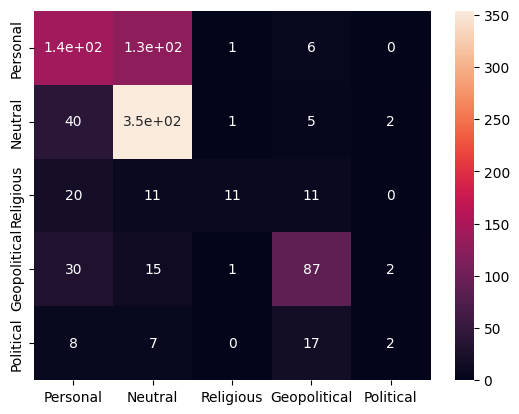

In [26]:
sns.heatmap(cf_matrix, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique())